### Overview

We will use pytorch for training our neural networks. First, we will look at the overall pipeline to train and validate the model. For this, we will use ML models from already available python pacakges like ``dgl`` and ``deepchem``.


The process of training and validating model is below --

1. Clean up dataset
2. Featurize the data
3. Split the dataset
4. Create ``DataLoader`` for the dataset splits
5. Create the ML model, define loss function and optimizer
6. ``for`` loop for epochs
    1. ``for`` loop for training batches
        1. Do a forward pass
        2. Compute the loss
        3. Do backpropogation
    2. ``for`` loop for validation batches
        1. Do a forward pass
        2. Compute the loss
    

### Installing the packages

In [1]:
# install deepchem, dgl, rdkit and fast-ml
! pip install deepchem
! pip install dgl
! pip install dgllife
! pip install rdkit
! pip install fast_ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 53.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.3
    Uninstalling scipy-1.11.3:
      Successfully uninstalled scipy-1.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
jax 0.4.20 requires scipy>=1.9, but you have scipy 1.8.1 which is incompatible.
jaxlib 0.4.20+cuda11.cudnn86 requires scipy>=1.9, but you have scipy 1.8.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━

### Dataset operations

We will fetch the QM9 dataset and use HOMO-LUMO gap as the target for prediction.

In [2]:
# import pandas library
import pandas as pd

# load the dataframe as CSV from URL.
df = pd.read_csv("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv")

# create the dataset with smiles and gap
dataset = df[["smiles","gap"]]

For featurizing the SMILES, we will use ``CircularFingerprint`` from deepchem.

In [3]:
# import depechem and rdkit
import deepchem as dc
from rdkit import Chem

# create the featurizer object
featurizer = dc.feat.CircularFingerprint(radius=2, size=100)

# apply the featurizer to dataset
dataset["fp"] = dataset["smiles"].apply(featurizer.featurize)

# the fp is an array; we will convert it to a list as required for model input
dataset["fp"] = dataset["fp"].apply(lambda x: list(x[0]))

# just use the fp and gap part of the dataset
dataset = dataset[["fp","gap"]]

<ipython-input-3-a48f0833e7a3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["fp"] = dataset["smiles"].apply(featurizer.featurize)
<ipython-input-3-a48f0833e7a3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["fp"] = dataset["fp"].apply(lambda x: list(x[0]))


Here, we use random splitting with Fast-ML. Other splitters could also be used.

In [4]:
# import the function to split into train-valid-test
from fast_ml.model_development import train_valid_test_split

X_train, y_train, X_valid, y_valid, \
X_test, y_test = train_valid_test_split(dataset, target = "gap", train_size=0.8,
                                        valid_size=0.1, test_size=0.1)

Checking the dataset before procceding.

In [5]:
X_test.head()

,fp
48879,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
133459,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ..."
77180,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, ..."
87586,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
20037,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."


### Dataloader

The ``DataLoader`` helps in creating batches, shuffling data and feeding the data into to model during training. The dataloader requires the dataset in the form (X,y) where X is the input and y is the target.

The dataloader code below does this transformation. The ``collate_data`` function is need for batching the (X,y) entries before feeding the batches into the model.

In [6]:
def collate_data(data):
  # our data is in the form of list of (X,y)
  # the map function thus maps accordingly
  X, y = map(list, zip(*data))

  # we need to stack the Xs and ys for different entries in the batch
  X = torch.stack(X, dim=0)
  y = torch.stack(y, dim=0)
  return X, y

In [7]:
# import dataloader
import torch
from torch.utils.data import DataLoader

# create the dataloader for train dataset
# dataset should be of form (X,y) according to the collate function
# the inputs should also be converted to tensors
train_dataloader = DataLoader(
    dataset=list(zip(torch.tensor(X_train["fp"].values.tolist(), dtype=torch.float32),
                     torch.tensor(y_train.tolist(), dtype=torch.float32))),
    batch_size=64, collate_fn=collate_data)

We can look at the first entry of the train_dataloader with -

In [8]:
train_dataloader.dataset[0]

(tensor([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
         1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 tensor(0.2654))

Repeat the same for the valid_dataset and test_dataset

In [9]:
valid_dataloader = DataLoader(
    dataset=list(zip(torch.tensor(X_valid["fp"].values.tolist(), dtype=torch.float32),
                     torch.tensor(y_valid.tolist(), dtype=torch.float32))),
    batch_size=64, collate_fn=collate_data)

test_dataloader = DataLoader(
    dataset=list(zip(torch.tensor(X_test["fp"].values.tolist(), dtype=torch.float32),
                     torch.tensor(y_test.tolist(), dtype=torch.float32))),
    batch_size=64, collate_fn=collate_data)

### Model, loss and optimizer

ML models architectures are already available in many python packages including deepchem, dgl-lifesci, chemprop, chemml.

Here, we will use a model from dgl-lifesci package to show the process of training a ML model. deepchem has a streamlined process and you cannot see what happens behind the scene. We will look at one such implementation later.

In [10]:
# import MLP model from dgl-lifesci
from dgllife.model.model_zoo.mlp_predictor import MLPPredictor

model = MLPPredictor(in_feats=100, hidden_feats=512, n_tasks=1, dropout=0.)
model

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


MLPPredictor(
  (predict): Sequential(
    (0): Dropout(p=0.0, inplace=False)
    (1): Linear(in_features=100, out_features=512, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)

The ``MLPPredictor`` is a simple two layer model with dropout, batchnorm and ReLU activation. This alone may not be a good model, but is inexpensive for training demonstration.

Once the model is created, we can set the loss function

In [11]:
# loss function for regresssion is usually mean squared error
import torch

loss_func = torch.nn.MSELoss(reduce=None)

We will use the Adam optimizer for training.

In [12]:
# adam optimier
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Model training and validation

We follow the steps in the overview

In [13]:
epochs = 5

# loop over epochs
for epoch in range(epochs):
  print("\nStarting Epoch", epoch+1)

  model.train()
  # loop over training batches

  train_loss = []
  for batch in train_dataloader:

    # Do a forward pass
    feats, target = batch
    predictions = model(feats)

    # Compute loss and gradient
    loss = (loss_func(predictions, target)).mean()
    optimizer.zero_grad()

    # Do back propogation
    loss.backward()
    optimizer.step()

    # save loss to compute average loss
    train_loss.append(loss)

  print("Training loss", torch.tensor(train_loss).mean().item())


  # loop over validation batches
  model.eval()
  valid_loss = []
  with torch.no_grad():
    for batch in valid_dataloader:

      # Do a forward pass
      feats, target = batch
      predictions = model(feats)

      # Compute loss and gradient
      loss = (loss_func(predictions, target)).mean()
      valid_loss.append(loss)
  print("Validation loss ", torch.tensor(valid_loss).mean().item())



Starting Epoch 1
Training loss 0.007861745543777943
Validation loss  0.0023489021696150303

Starting Epoch 2
Training loss 0.002469493541866541
Validation loss  0.0029704011976718903

Starting Epoch 3
Training loss 0.0026531554758548737
Validation loss  0.0025452375411987305

Starting Epoch 4
Training loss 0.002550845965743065
Validation loss  0.0024154025595635176

Starting Epoch 5
Training loss 0.0023934156633913517
Validation loss  0.002320339670404792


### Testing the performance

We can get a random sample from the test dataset and look at the predicted and true value

In [14]:
idx = 159
x_sample = X_test["fp"].iloc[idx]
y_sample = y_test.iloc[idx]

y_sample

0.2871

In [15]:
model.eval()
model(torch.tensor([x_sample], dtype=torch.float32))

tensor([[0.2517]], grad_fn=<AddmmBackward0>)

Let us get prediction over the entire test dataset

In [16]:
predicted_values = []
true_values = y_test.to_list()

model.eval()
for sample in X_test["fp"].tolist():
   prediction = model(torch.tensor([x_sample], dtype=torch.float32))
   predicted_values.append(prediction.item())

We can create a scatter plot to look at the correlation

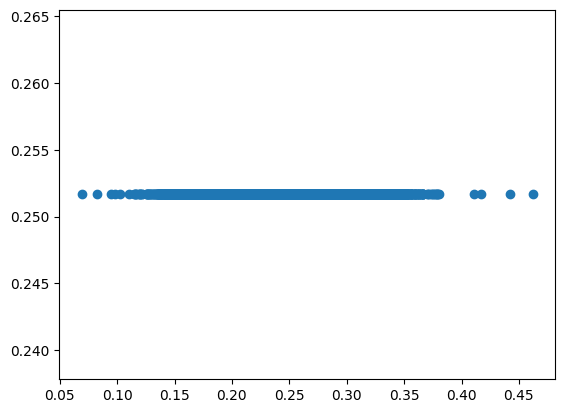

In [17]:
import matplotlib.pyplot as plt

plt.scatter(true_values, predicted_values)

As we noted before, the model predictions are not good; predicts nearly constant value. We can also arrive at the conclusion from the R<sup>2</sup> score

In [18]:
from sklearn.metrics import mean_absolute_error, r2_score

print("R2 score ", r2_score(true_values, predicted_values))

R2 score  -1.3436513860431987e-05
